In [27]:
import torch.nn.functional as F
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
import pandas as pd
import cv2

# CNN

In [9]:
# Load the image
image = Image.open("data/actual/train/patient14104/study2/view1_frontal.jpg")
if image.mode != "RGB":
    image = image.convert("RGB")
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
input_tensor = preprocess(image)
input_tensor = input_tensor.unsqueeze(0)
if torch.cuda.is_available():
    input_tensor = input_tensor.cuda()

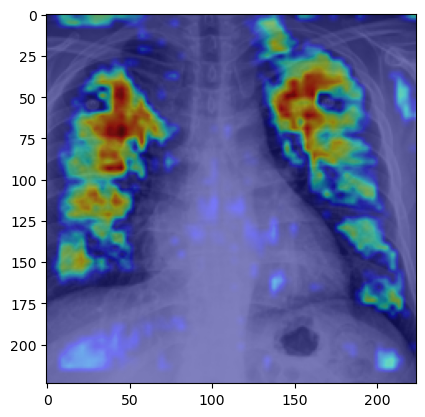

In [23]:
def compute_gradcam(model, input_tensor, target_layer):
    # Lists to store the gradients and activations
    gradients = []
    activations = []

    # Hook to store the gradients
    def gradient_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Hook to store the activations
    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks
    gradient_handle = target_layer.register_full_backward_hook(gradient_hook)
    activation_handle = target_layer.register_forward_hook(forward_hook)

    # Forward pass
    output = model(input_tensor)

    # Zero grads
    model.zero_grad()

    # Backward pass with respect to the specific class index
    pred_class = output.argmax().item()
    one_hot_output = torch.FloatTensor(1, output.shape[-1]).zero_()
    one_hot_output[0][pred_class] = 1
    if torch.cuda.is_available():
        one_hot_output = one_hot_output.cuda()
    output.backward(gradient=one_hot_output)

    # Remove the hooks
    gradient_handle.remove()
    activation_handle.remove()

    # Compute the gradient-weighted CAM
    gradients_val = gradients[0].cpu().data.numpy()
    activations_val = activations[0].cpu().data.numpy()
    weights = np.mean(gradients_val, axis=(2, 3))
    cam = np.zeros(activations_val.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights[0]):
        cam += w * activations_val[0, i, :, :]

    # Relu on the CAM to get only the positive effect
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    
    return cam

model = torch.load("checkpoints/CNN_archive/set_14_epc_3.pt", map_location="cpu")
model.eval()
if torch.cuda.is_available():
    model = model.cuda()

# Using the method:
target_layer = model.conv3
cam = compute_gradcam(model, input_tensor, model.conv3)

# Displaying the image
import matplotlib.pyplot as plt
plt.imshow(image)
plt.imshow(cam, alpha=0.5, cmap="jet")
plt.show()


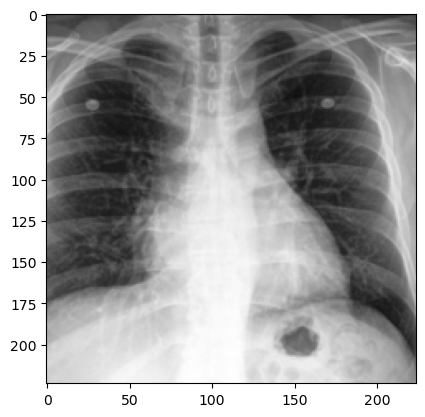

In [24]:
plt.imshow(image)
plt.show()

# IRENE

In [26]:
from helper import Data, load_pkl
from torch.utils.data import DataLoader

from tqdm import tqdm
from torch import nn

  0%|          | 0/1 [00:00<?, ?it/s]

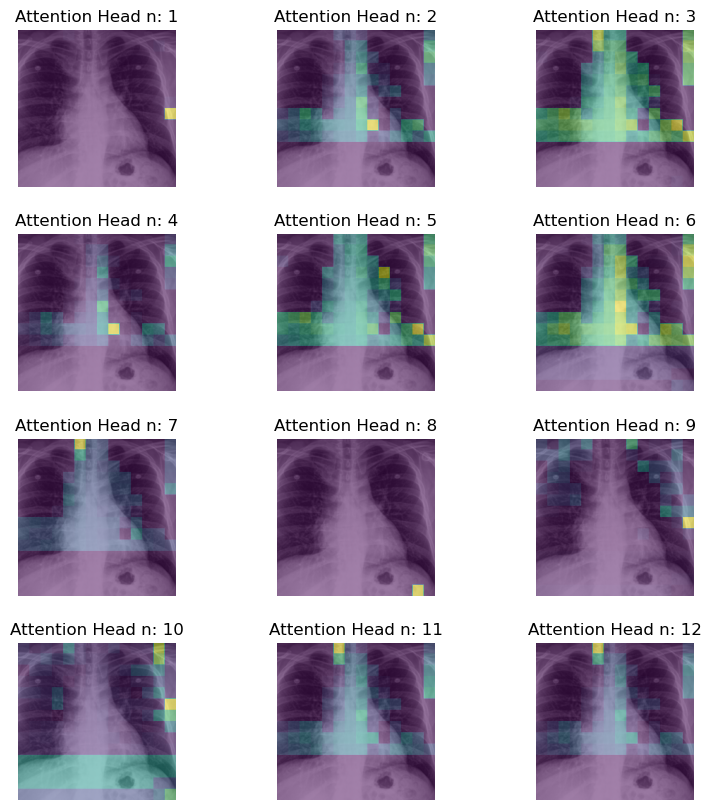

100%|██████████| 1/1 [00:14<00:00, 14.59s/it]


In [28]:
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}

# point to your pkl file
pkl_train_dict = load_pkl("./data/actual/train_0.pkl")
# point to the root directory of your image files
img_dir = "./data/actual/"
# the key of the image in the pkl file you are referencing 
img_key = "train/patient14104/study2/view1_frontal.jpg"

# create dict with a single image (use one of the keys located in the pkl file)
single_dict = { img_key : pkl_train_dict[img_key]}

# Create Train Dataset and DataLoader object 
data = Data(single_dict, img_dir, transform=data_transforms['test'])
loader = DataLoader(data, batch_size=1, shuffle=False, num_workers=12, pin_memory=True)

# load saved model
model = torch.load("./checkpoints/set_8_epc_7.pt")

model.eval()
for item in tqdm(loader):
    # max length of tokens. Default to 40, don't change
    TK_LIM = 40

    # Reuse the some of the code to get inputs into the correct format
    imgs, labels, cc, demo, lab = item

    imgs = imgs.cuda(non_blocking=True)
    cc = cc.view(-1, TK_LIM, cc.shape[3]).cuda(non_blocking=True).float()
    lab = lab.view(-1, lab.shape[1], 1).cuda(non_blocking=True).float()
    demo = demo.view(-1, 1, demo.shape[1]).cuda(non_blocking=True).float()
    sex = demo[:, :, 1].view(-1, 1, 1).cuda(non_blocking=True).float()
    age = demo[:, :, 0].view(-1, 1, 1).cuda(non_blocking=True).float()
    
    with torch.no_grad():

        # setting labels = None allows us to get the attention weights
        logits, attn_weights, _ = model(imgs, cc, lab, sex, age, labels=None)

        ####### Begin code to generate attention patches ######

        img = imgs.squeeze()
        patch_size = 16

        w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - \
            img.shape[2] % patch_size

        img = img[:, :w, :h].unsqueeze(0)

        w_featmap = img.shape[-2] // patch_size
        h_featmap = img.shape[-1] // patch_size

        attentions = attn_weights[-1]

        nh = attentions.shape[1]  # number of head

        # keep only the output patch attention.
        # 57 = 253 - 196 
        attentions = attentions[0, :, 0, 57:].reshape(nh, -1)

        attentions = attentions.reshape(nh, w_featmap, h_featmap)
        attentions = nn.functional.interpolate(attentions.unsqueeze(
            0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
    
    ###### Begin image output ##############
    # convert dataloader image to np
    image = np.transpose(imgs.cpu().numpy()[0], (1,2,0))

    # Create a 4x4 grid of subplots
    fig, axes = plt.subplots(4, 3, figsize=(10, 10))

    # Loop through the images and plot them in the grid
    for i, ax in enumerate(axes.flat):
        ax.imshow(image)
        ax.imshow(attentions[i], alpha=.5)
        ax.set_title(f"Attention Head n: {i+1}")
        ax.axis('off')  # Turn off axis labels and ticks

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.005, hspace=0.3)

    # Show the grid of images
    plt.show()